# Projection Methods - A Simple Example

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook, I use a simple projection technique to solve the discrete time neo-classical growth model. 

This notebook is heavily inspired by Matlab codes from [Prof. Wouter den Haan](http://www.wouterdenhaan.com/summercourse_essentials.html) at LSE. The notebook is essentially a Python version of the code with explanatory notes and some minor improvements.

We start by doing some imports:

In [1]:
# Computational imports
import numpy as np
from scipy import optimize as opt
from numba import jit

# Graphics imports
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns  # Better quality figures
from matplotlib import rcParams
rcParams['figure.figsize'] = (9, 6)  # Sets the size of the figures in the notebook
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting

## 1. Model

This is a simple standard neo-classical growth model in discrete time. It has two state variables: $k_t$, the current period stock of capital, and $z_t$, the TFP level, and two choice variables $c_t$, current period consumption, and $k_{t+1}$, the next period stock of capital. 

A solution to the model has to satisfy the following system of equilibrium equations at each period $t$:

$$
\begin{align}
c_t^{-\nu} &= \mathbb{E}_t \left[ \beta c_{t+1}^{-\nu}(\alpha z_{t+1} k_{t+1}^{\alpha-1} +1 - \delta)\right] 
\\
c_t + k_{t+1} &= z_t k_t^\alpha + (1 - \delta) k_t
\\
\ln(z_{t+1}) &= \rho \ln(z_t) + \varepsilon_{t+1}
\end{align}
$$

with $\varepsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$ and taking the initial conditions $k_1$, $z_1$ as given.

One way of tackling this problem numerically is to solve directly for the optimal policy functions 
$$
\begin{align}
c_t &= c(k_t, z_t)
\\
k_{t+1} &= k(k_t,c_t)
\end{align}
$$
mapping the state variables $k_t$ and $z_t$ to the optimal choice variables $c_t$ and $k_{t+1}$. Of course, the functional forms of these policy functions are unknown.

Notice that by solving for $c_t$ we can recover $k_{t+1}$ using the budget constraint. This allows us to simply focus on finding the consumption policy function $c(k_t, z_t)$.

## 2. Numerical Solution

The idea behind the projection method is to find a polynomial $P_n$ which approximates the policy function
$$
c_t = c(k_t,z_t) \approx P_n(k_t,z_t;\eta_t)
$$

We start by defining consumption as a function of the state variables and the polynomial coefficients. We choose a polynomial of order 2:

In [2]:
# Consumption policy function approximation
@jit
def c_poly(k,z,eta):
    c_log = eta[0] + eta[1]*np.log(k) + eta[2]*np.log(z) + eta[3]*np.log(k)**2 + eta[4]*np.log(z)**2 + eta[5]*np.log(k)*np.log(z)
    return np.exp(c_log)

All what we have to do now is to solve for the polynomial coefficients $\eta_n$.

For that we require that the polynomial minimizes the following error derived from the Euler equation:

$$
e(k_i,z_i;\eta_n) = - P_n(k_i,z_i;\eta_n)^{-\nu} + \mathbb{E} \left[ \beta P_n(k',z';\eta_n)^{-\nu}(\alpha z'k'^{\alpha-1} +1-\delta )\right]
$$

Replacing $k'$ and $z'$ by their model expressions we get:
$$
e(k_i,z_i;\eta_n) = - P_n(k_i,z_i;\eta_n)^{-\nu} + \mathbb{E} \left[ \beta P_n(z_i k_i^\alpha + (1-\delta)k_i - P_n(k_i,z_i;\eta_n),e^{\rho\ln{z_i} + \varepsilon'};\eta_n)^{-\nu} \alpha e^{\rho\ln{z_i} + \varepsilon'}(z_i k_i^\alpha + (1-\delta)k_i - P_n(k_i,z_i;\eta_n))^{\alpha-1} \right]
$$

In [3]:
@jit
def griderr(eta):
    """
    Returns the sum of squared Euler errors at all grid points
    
    """
    
    ssr      =  0  # Initialize the sum of squared errors
    
    for i_k in range(len(k_grid)):  # Iterate over k and z grids
        for i_z in range(len(z_grid)):
            k       = k_grid[i_k]
            z       = z_grid[i_z]
            c       = c_poly(k,z,eta)
            k_prime = z*k**alpha+(1-delta)*k-c;
            
            # Calculating the expectation over the GH nodes for every (k,z) weighted by the GH weights
            expec  = 0
            for i_q in range(q_number):
                e_prime = np.sqrt(2)*sigma*q_nodes[i_q]  # The errors are normally distributed with mean 0 and std sigma
                z_prime = np.exp(rho*np.log(z)+e_prime)
                c_prime = c_poly(k_prime,z_prime,eta)
                
                expec = expec + q_weights[i_q]*beta*c_prime**(-gamma)*(alpha*z_prime*k_prime**(alpha-1)+(1-delta))            
                
            expec = expec/np.sqrt(np.pi)      
            ssr = ssr + (expec-c**(-gamma))**2

    return ssr

With the two functions above defined, we can try to solve this problem numerically.

First, we set values for the model's parameters:

In [4]:
beta  = 0.99
alpha = 0.33
delta = 0.025
gamma = 4
rho   = 0.95
sigma = 0.1

The steady state capital level is:
$$
k_{ss} = \left(\frac{\beta \alpha}{1-\beta(1-\delta)}\right)^{\frac{1}{1-\alpha}}
$$

In [5]:
# Calculate the steady state level of capital
k_ss = (beta*alpha/(1-beta*(1-delta)))**(1/(1-alpha))

Next, we set up grids for the two state variables: $k$ and $z$. The grid for capital will be centered around $k_{SS}$ and the grid for $z_t$ will be centered around its unconditional mean:

In [6]:
# Setting up the capital grid
k_low    =  0.5*k_ss
k_high   =  1.5*k_ss
k_number =  10
k_grid = np.linspace(k_low,k_high,k_number)

# Setting up the productivity grid
z_low    = -3 * np.sqrt(sigma**2/(1-rho**2))
z_high   =  3 * np.sqrt(sigma**2/(1-rho**2))
z_number =  10 
z_grid  = np.exp(np.linspace(z_low,z_high,z_number))

In order to compute the expectation term, we use numerical integration and in particular the [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature). We simply choose the number of nodes and then use the Numpy function `hermgauss` to generate the nodes and weights as follows:

In [7]:
q_number = 5  # Number of nodes and weights for the Gauss-Hermite quadrature

# Use the hermgauss function to get the nodes and the weights for the Gauss-Hermite quadrature
q_nodes, q_weights = np.polynomial.hermite.hermgauss(q_number)

Now that we have everything in place, we can pass the error function to a minimization routine in order to solve for the coefficients that minimize the squared sume of Euler errors:

In [8]:
#%%timeit

# Set initial values for the coefficients
init_eta = np.zeros((1, 6))

# Find solution by minimizing the errors on the grid
opt_eta = opt.minimize(griderr,init_eta,method='Nelder-Mead',options={'disp':True,'maxiter':100000,'xtol': 1e-10,'ftol': 1e-10}).x
print(opt_eta)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1676
         Function evaluations: 2621
[-0.25743885  0.26136135  0.70784042  0.01272939  0.04221251 -0.10243451]


Next, we plot the optimal consumption choice $c$ as a function of the level of capital $k$ for 3 different values of productivity $z$. Notice that since we solved for the approximating polynomial coefficients, we can use a much finer grid for plotting.

<IPython.core.display.Javascript object>


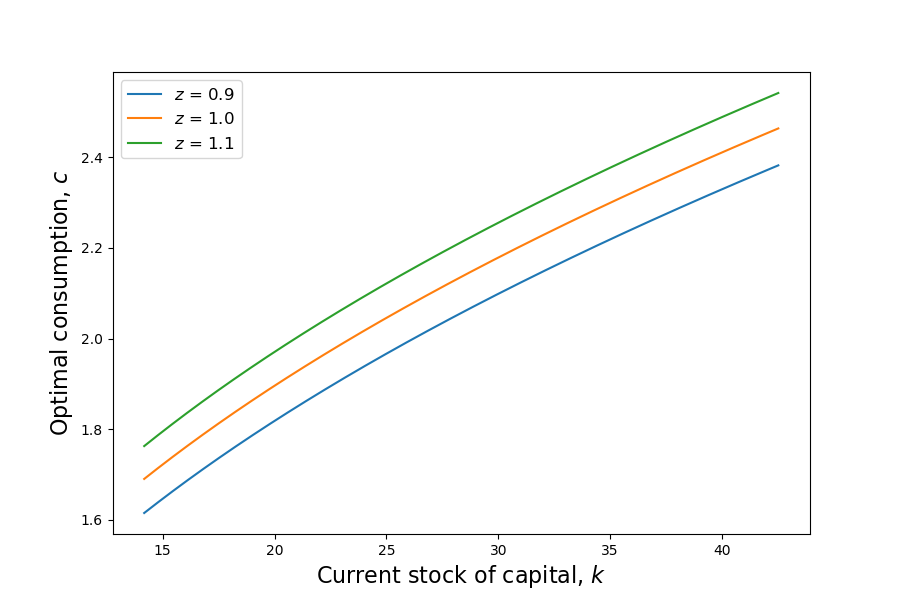

In [9]:
k_grid_fine = np.linspace(k_low,k_high,1000)

plt.figure()
plt.plot(k_grid_fine,c_poly(k_grid_fine,0.9,opt_eta),label=r'$z$ = 0.9')
plt.plot(k_grid_fine,c_poly(k_grid_fine,1.0,opt_eta),label=r'$z$ = 1.0')
plt.plot(k_grid_fine,c_poly(k_grid_fine,1.1,opt_eta),label=r'$z$ = 1.1')
plt.legend(loc='best',fontsize=12)
plt.xlabel(r'Current stock of capital, $k$',fontsize=16)
plt.ylabel(r'Optimal consumption, $c$',fontsize=16)
plt.show()

I also produce a 3d plot of $c_t$ as a function of $k_t$ and $z_t$:

<IPython.core.display.Javascript object>


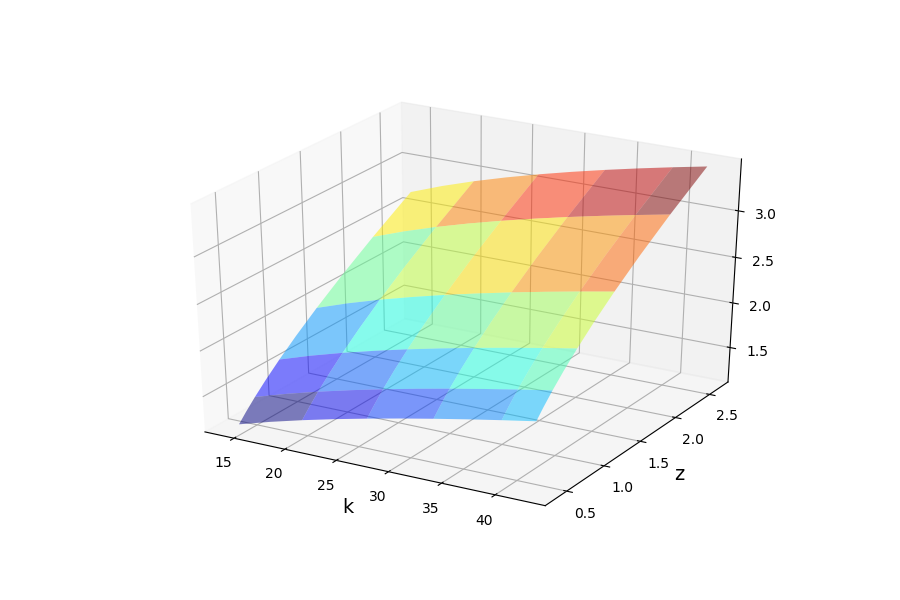

In [10]:
# Generate meshgrid coordinates for 3d plot
kg, zg = np.meshgrid(k_grid, z_grid)

# Plot policy function approximation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kg,
                zg,
                c_poly(kg,zg,opt_eta),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('z', fontsize=14)
plt.show()